In [1]:
from loadphantom import BreastPhantomReader
file_path = "../../data/breast/"
reader = BreastPhantomReader(file_path)

Phantom ID 012304 loaded successfully.
Dimensions (s1, s2, s3): (215, 328, 212)
Classification: 4


In [2]:
freq = 1. # GHz
epsilon_r, sigma = reader.calculate_dielectric_properties(
    freq, model='cole-cole'
)

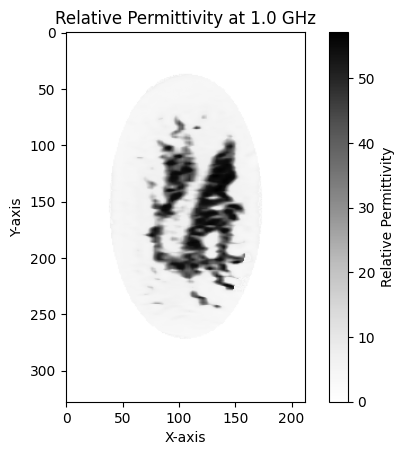

In [3]:
from matplotlib import pyplot as plt
plt.imshow(epsilon_r[140, :, :], cmap='Greys')
plt.colorbar(label='Relative Permittivity')
plt.title(f'Relative Permittivity at {freq} GHz')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

Degrees of freedom: 17


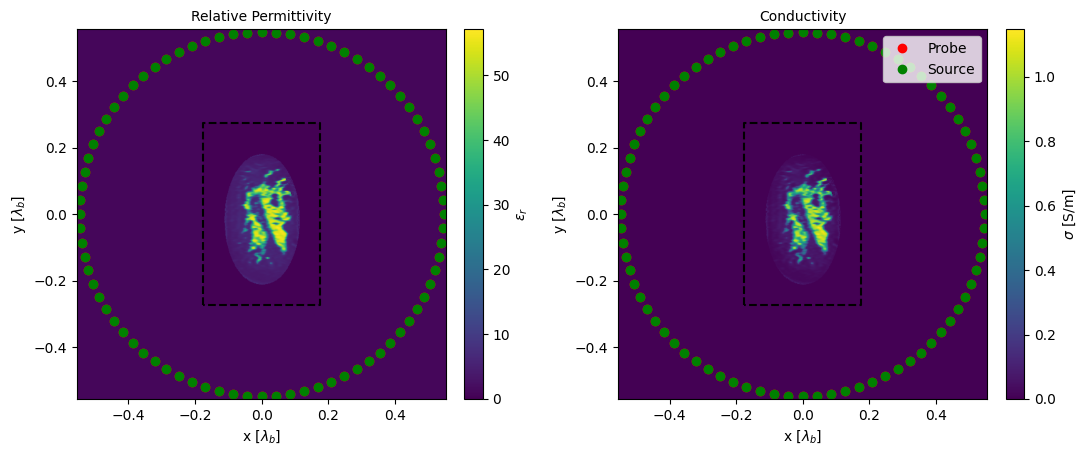

In [4]:
import numpy as np
import sys
sys.path.insert(1, '../../eispy2d/library/')
import configuration as cfg

epsr = np.squeeze(epsilon_r[140, :, :])
sig = np.squeeze(sigma[140, :, :])

instance_name = 'breastphantom'
dx = dy = 0.5e-3 # 0.5 mm
Lx, Ly = epsr.shape[1] * dx, epsr.shape[0] * dy
max_epsilon_r = epsr.max()
object_radius = min([Lx, Ly]) / 2.0
DOF = cfg.degrees_of_freedom(object_radius, frequency=freq*1e9,
                             epsilon_r=max_epsilon_r)
print(f"Degrees of freedom: {DOF}")
NS = NM = 80
Ro = max([Lx, Ly])
epsilon_rb = 1.
sigma_b = 0.
image_size = [Ly, Lx]
E0 = 1.

config = cfg.Configuration(name=instance_name + '.cfg',
                           number_measurements=NM,
                           number_sources=NS,
                           observation_radius=Ro,
                           frequency=freq*1e9,
                           background_permittivity=epsilon_rb,
                           background_conductivity=sigma_b,
                           image_size=image_size,
                           wavelength_unit=False,
                           magnitude=E0)

config.draw(epsr=epsr, sig=sig, show=True)

In [5]:
import inputdata as ipt
import result as rst

test = ipt.InputData(name=instance_name + '.ipt',
                     configuration=config,
                     rel_permittivity=epsr,
                     conductivity=sig,
                     indicators=[rst.SHAPE_ERROR, rst.POSITION_ERROR,
                                 rst.OBJECTIVE_FUNCTION])
test.compute_dnl()
print(test)

Input name: breastphantom.ipt
Configuration file: breastphantom.cfg
Images Resolution: 328x212
Relative Permit. map shape: 328x212
Conductivity map shape: 328x212
Indicators: ['zeta_s', 'zeta_p', 'objective_function']
Degrees of Non-Linearity: 0.8122


In [ ]:
import mom_cg_fft as mom
forward = mom.MoM_CG_FFT(tolerance=1e-3, maximum_iterations=5_000)
_ = forward.solve(test)